In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy as sc
from scipy.optimize import minimize
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy.optimize import newton
from scipy.optimize import root_scalar
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
from matplotlib import colors
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D

In [2]:
e      = 1.6*10**(-19)              #Charge of electron
hbar   = 1.054 * 10**(-34)          #SI  Js 
hbarev = 6.59*10**(-16)             #SI  eVs
me     = 9.1 * 10**(-31)            #SI  kg
meff   = 0.035*me                   #SI  kg
kb     = 1.38 * 10**(-23)           #SI  J/K
kbev   = 8.617 * 10**(-5)           #SI  eV/K
c      = 3*(10**8)                  #SI  m/s

omega  = 0.110                      #SI eV  interlayer hopping energy 
d      = 1.420 *10**(-10)           #SI m  C-C distance in graphene
vf     = 1.5*d*2.866/hbarev         #SI m/s, Fermi velocity for SLG  = 0.905 *10**(6)  #CORRECTED 2.866 for MA=1.05
N      = 1000                       #No. of landau leveles
N_con  = 500                        #No. of landau levels considering (should be less than or equal to N)

In [3]:
upper=Qobj([[0,1],[0,0]])
lower=Qobj([[0,0],[1,0]])

def hk_mono_LS(N_con,B,qx,qy,pos):              #Landau splitting about the dirac point of monolayer with respect to cyclotron frequency ,qx and qy are shifts
    
    lB = np.sqrt(hbar/(e*B))
    anhi     = destroy(N_con)
    
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 
    
    
    kx=0.5*(anhi+anhi.dag())/M_fac
    ky=0.5j*(anhi-anhi.dag())/M_fac
    
    hk=E_fac*(tensor((kx+qx)+1j*(ky+qy),upper)+tensor((kx+qx)-1j*(ky+qy),lower)).full()
    
    eigenvalue,featurevector=np.linalg.eigh(hk)
    eig_vals_sorted = np.sort(eigenvalue)
    
    if pos:
        eig_vals_sorted = eig_vals_sorted[-N_con:]
        return np.array(eig_vals_sorted)           # Returns Positive Eigenvalues 
    
    return eig_vals_sorted               #eigvals here is in eV

def bi_hk(N_con,B,pos):
      
    lB = np.sqrt(hbar/(e*B))
    anhi     = destroy(N_con)
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 

    
    kx=0.5*(anhi+anhi.dag())/M_fac
    ky=0.5j*(anhi-anhi.dag())/M_fac
    
    
    bi_hk= -(hbar**2/(2*meff*e))*(tensor((kx+1j*ky)**2,upper)+tensor((kx-1j*ky)**2,lower)).full()
    
    eigenvalue,featurevector=np.linalg.eigh(bi_hk)
    eig_vals_sorted = np.sort(eigenvalue)
    
    if pos:
        eig_vals_sorted = eig_vals_sorted[-N_con:]
        return np.array(eig_vals_sorted)
    
    return eig_vals_sorted               #eigvals here is in eV




ei120  = np.cos(2*np.pi/3) + 1j*np.sin(2*np.pi/3)
ei240  = np.cos(2*np.pi/3) - 1j*np.sin(2*np.pi/3)

# Hopping matrices

Tqb    = omega*np.array([[1,1], [1,1]], dtype=complex)
Tqtr   = omega*np.array([[ei240, 1], [ei120, ei240]], dtype=complex)
Tqtl   = omega*np.array([[ei120, 1], [ei240, ei120]], dtype=complex)
TqbD   = np.array(np.matrix(Tqb).H)
TqtrD  = np.array(np.matrix(Tqtr).H)
TqtlD  = np.array(np.matrix(Tqtl).H)


def  Hk_twist_landau_spec(N,B,theta,N_con):   #8 Band hamiltonain  #gives eigenvalues only about K(or K') point of 1st layer
    
    
    anhi     = destroy(N)
    lB = np.sqrt(hbar/(e*B))
    
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 
    I_n   = identity(N)
    
    sin_half = np.sin(theta/2)
    cos_half = np.cos(theta/2)
    
    
    ktheta   = 8*np.pi*sin_half/3/np.sqrt(3)/d                   #SI m^-1

    # Hopping vectors in k space
    
    qb      = ktheta*np.array([0, -1])
    qtr     = ktheta*np.array([np.sqrt(3)/2,0.5])
    qtl     = ktheta*np.array([-np.sqrt(3)/2,0.5])
    
    Hk      = np.array(np.zeros((8*N, 8*N)), dtype=complex)
    
    kx      = 0.5*(anhi+anhi.dag())/M_fac
    ky      = 0.5j*(anhi-anhi.dag())/M_fac
    
    
    qx      =  kx
    qy      =  ky
    qx1     =  (kx+qb[0])
    qy1     =  (ky+qb[1])
    qx2     =  (kx+qtr[0])
    qy2     =  (ky+qtr[1])
    qx3     =  (kx+qtl[0])
    qy3     =  (ky+qtl[1])
    
    
    H11     = -E_fac*(tensor((qx+1j*qy),upper)+tensor((qx-1j*qy),lower)).full()  
    H22     = -E_fac*(tensor((qx1+1j*qy1),upper)+tensor((qx1-1j*qy1),lower)).full()
    H33     = -E_fac*(tensor((qx2+1j*qy2),upper)+tensor((qx2-1j*qy2),lower)).full()
    H44     = -E_fac*(tensor((qx3+1j*qy3),upper)+tensor((qx3-1j*qy3),lower)).full()

   
    Hk[0:2*N,0:2*N]       = H11
    Hk[2*N:4*N,2*N:4*N]   = H22
    Hk[4*N:6*N,4*N:6*N]   = H33
    Hk[6*N:8*N,6*N:8*N]   = H44
    Hk[0:2*N,2*N:4*N]     = tensor(I_n,Qobj(Tqb)).full()
    Hk[0:2*N,4*N:6*N]     = tensor(I_n,Qobj(Tqtr)).full()
    Hk[0:2*N,6*N:8*N]     = tensor(I_n,Qobj(Tqtl)).full()
    Hk[2*N:4*N,0:2*N]     = tensor(I_n,Qobj(TqbD)).full()
    Hk[4*N:6*N,0:2*N]     = tensor(I_n,Qobj(TqtrD)).full()
    Hk[6*N:8*N,0:2*N]     = tensor(I_n,Qobj(TqtlD)).full()
    

    Hk = csr_matrix(Hk, dtype=complex)
    
    eigenvalues, eigenvectors = eigsh(Hk, k=2*N_con, sigma=1e-8, tol=1e-12)   #Return just this for all eigenvalues
    final_eigenvalues = np.sort(np.abs(np.round(eigenvalues)))[::2]

    return final_eigenvalues                #eigvals here is in eV



In [4]:
def therm_prob_not_norm(T,E):
    Thermal_probs= np.exp(-E/(kbev*T)) #make sure E is in eV as kbev is in ev/K
    Z_state = np.sum(Thermal_probs)     
    return Thermal_probs/Z_state



def Vn_entropy_therm_prob(L):
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    S = -kbev*np.sum(np.where(L > 0, L * np.log(L + epsilon), 0))
    return S


def find_temperature(Prob_ref, E_test,T_guess, T_bounds=(1e-3, 1000)):
    """Find temperature where S(T) = S_ref using Brent's method"""
    try:
        result = root_scalar(
            lambda T: entropy_difference(T, Prob_ref, E_test),
            bracket=T_bounds,
            method='brentq',
            xtol=1e-6
        )
        return result.root
    except ValueError:
        print(f"Failed to converge for E_test={E_test}, trying fallback...")
        # Fallback to Newton with good guess
        return find_root_newton(Prob_ref, E_test, T_guess)

def Heat(E,P1,P2):
    Q=np.sum(E*(P1-P2))
    return Q     #in eV if E is in eV

def Work_sys(P,E1,E2):
    W=np.sum(P*(E1-E2))
    return W


def find_root_newton(Prob_ref, E_test, T_guess, max_iter=5000, tol=1e-5):
    result = newton(func=lambda T: entropy_difference(T, Prob_ref, E_test), x0=T_guess, fprime=None, tol=tol, maxiter=max_iter)
    return result



def entropy_difference(T_test, Prob_ref, E_test):
    Prob_test = therm_prob_not_norm(T_test,E_test)

    S_ref = Vn_entropy_therm_prob(Prob_ref).real
    S_test = Vn_entropy_therm_prob(Prob_test).real

    return S_ref - S_test 



In [5]:
def QSC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type,saved):
    
    B2 = B1 * rc
    Prob_A = therm_prob_not_norm(T_cold, Energy_B1)

    try:
        if Type=="Performance":
            
            if saved == True:
            
                if isinstance(theta, (int, float)): 
                    filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"  #NEW PART
                    data = np.load(filename)
                    B_vals = data["B_vals"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(B_vals - B2))
                    Energy_B2 = spectra[idx]
        
                else: 
                    filename = f"spectrum_B_1T_N{N}_theta{theta}_Ncon{N_con}_rc1000.npz"
                    data = np.load(filename)
                    B_vals = data["B_vals"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(B_vals - B2))
                    Energy_B2 = spectra[idx]
        
                
            else:
            
                if isinstance(theta, (int, float)): 
                    Energy_B2 = Hk_twist_landau_spec(N,B2,theta,N_con)
                    
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)


        elif Type=="Twist":
            
            if saved == True:
            
                if isinstance(theta, (int, float)): 
                    data = np.load(f"spectrum_theta_sweep_N{N}_rc{rc}_Ncon{N_con}_steps80.npz")
                    theta_vals_deg = data["theta_vals_deg"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(theta_vals_deg - np.round(np.degrees(theta),2)))
                    closest_theta = theta_vals_deg[idx]
                    Energy_B2 = spectra[idx]
                
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)

            else :
                
                if isinstance(theta, (int, float)): 
                    Energy_B2 = Hk_twist_landau_spec(N,B2,theta,N_con)
                    
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)

        Prob_B = therm_prob_not_norm(T_cold, Energy_B2)
        
        SA=Vn_entropy_therm_prob(Prob_A)
        SB=Vn_entropy_therm_prob(Prob_B)

        QAB=T_cold*(SB-SA)

    

        Prob_C=therm_prob_not_norm(T_hot, Energy_B2)

        QBC=np.sum(Energy_B2*(Prob_C-Prob_B))


        Prob_D = therm_prob_not_norm(T_hot, Energy_B1)

        SC=Vn_entropy_therm_prob(Prob_C)
        SD=Vn_entropy_therm_prob(Prob_D)

        QCD=T_hot*(SD-SC)

        QDA=np.sum(Energy_B1*(Prob_A-Prob_D))
            
        Q_values = [QAB, QBC, QCD, QDA]
        Q_values1 = [float(val)*1000 for val in Q_values]  
        rounded_Q = [round(q, 3) for q in Q_values1]
        
        Heat_in = QCD+QBC
        Heat_out= QAB+QDA

        Work = Heat_in + Heat_out
        eff = Work / Heat_in
        COP_R_CP = np.abs(Heat_out) / np.abs(Work)
        COP_JP = (np.abs(Heat_out) + np.abs(Heat_in)) / np.abs(Work)

        #print(f"{rc:.4f}, Qi = {Heat_in:.6f}, Qo = {Heat_out:.6f}, "
        #      f"W = {Work:.6f}, ef = {eff:.4f}, Cp1 = {COP_R_CP:.3f}, Cp2 = {COP_JP:.3f}")

        return Heat_in, Heat_out, Work, eff, COP_R_CP, COP_JP

    except Exception as e:
        print(f"Skipping rc={rc} due to non-convergence: {e}")
        return None, None, None, None, None, None

/var/folders/j9/mv8r31ws7gd9xn1rn1c8gjnr0000gn/T/ipykernel_89491/4271677254.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  COP_R_CP = np.abs(Heat_out) / np.abs(Work)
/var/folders/j9/mv8r31ws7gd9xn1rn1c8gjnr0000gn/T/ipykernel_89491/4271677254.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  COP_JP = (np.abs(Heat_out) + np.abs(Heat_in)) / np.abs(Work)


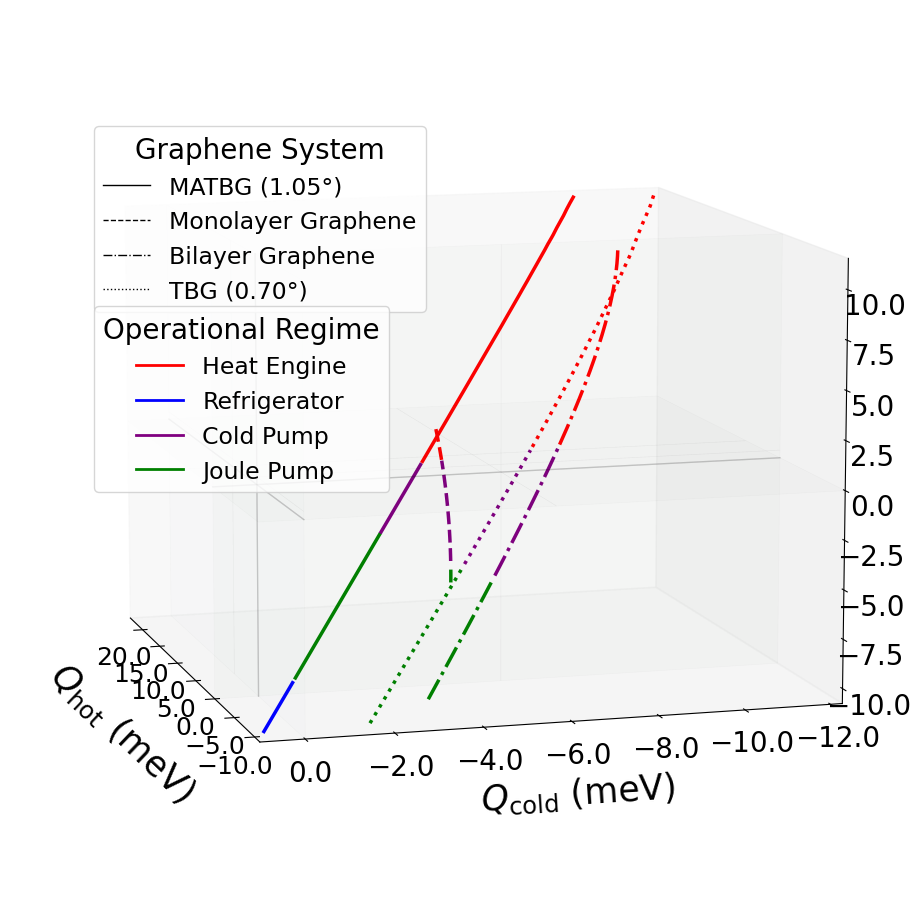

In [6]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Multiple hot temperatures

B1 = 1  # Magnetic field in Tesla

Theta_deg = ["Monolayer","Bilayer",0.7,1.05]
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]

Ratio = np.linspace(0.3, 4, 480)


regime_colors = {
    "engine": "red",
    "refrigerator": "blue",
    "cold_pump": "purple",
    "joule_pump": "green",
    "unknown": "gray"
}
regime_labels = {
    "engine": "Heat Engine",
    "refrigerator": "Refrigerator",
    "cold_pump": "Cold Pump",
    "joule_pump": "Joule Pump",
    "unknown": "Unknown"
}


theta_line_styles = {
    "Monolayer": "--",  # dashed line
    "Bilayer": "-.",    # dash-dot line
    0.70: ":" ,          # solid line
    1.05: "-"           # solid line
}

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)

all_Qin_data = []
all_Qout_data = []
all_work_data = []

present_regimes = set()

for theta in Theta:
    
    all_Qin = []
    all_Qout = []
    all_work = []
    heat_categories = []
    
    all_T_4, all_T_2 = [], []
    all_T_2.append(T_cold)
    all_T_4.append(T_hot)

    Count = 0
        
    if isinstance(theta, (int, float)):
        
        filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"
        data = np.load(filename)
        B_vals = data["B_vals"]
        spectra = data["spectra"]    
        idx = np.argmin(np.abs(B_vals - B1))
        Energy_B1 = spectra[idx]
    
    elif theta == "Monolayer":
        Energy_B1 = hk_mono_LS(N_con, B1, 0, 0, True)
    
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)

    for rc in Ratio:
        
        Heat_in, Heat_out, work, eff, COP_R_CP, COP_JP = QSC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Performance",saved=True)
       
        
        if eff is None or np.round(work, 5) == 0:
            continue
            
        
        all_Qin.append(Heat_in * 1000)
        all_Qout.append(Heat_out * 1000)
        all_work.append(work * 1000)

        if Heat_in > 0 and Heat_out < 0 and work > 0:
            current_category = "engine"
        elif Heat_in < 0 and Heat_out > 0 and work < 0:
            current_category = "refrigerator"
        elif Heat_in > 0 and Heat_out < 0 and work < 0:
            current_category = "cold_pump"
        elif Heat_in < 0 and Heat_out < 0 and work < 0:
            current_category = "joule_pump"
        else:
            current_category = "unknown"
            
        heat_categories.append(current_category)
    
    

    all_Qin = np.array(all_Qin)
    all_Qout = np.array(all_Qout)
    all_work = np.array(all_work)
    heat_categories = np.array(heat_categories)
    

    all_Qin_data.extend(all_Qin)
    all_Qout_data.extend(all_Qout)
    all_work_data.extend(all_work)
    
    present_regimes.update(set(heat_categories))

    if isinstance(theta, (int, float)):
        line_style = theta_line_styles[np.round(np.degrees(theta),2)]
    else:
        line_style = theta_line_styles[theta]
    
    unique_regimes, regime_codes = np.unique(heat_categories, return_inverse=True)
    

    if len(regime_codes) > 1:
        break_points = np.where(np.diff(regime_codes) != 0)[0] + 1
        segments = np.split(np.arange(len(heat_categories)), break_points)
    else:
        segments = [np.arange(len(heat_categories))]
    

    for seg in segments:
        if len(seg) == 0:
            continue
            
        current_regime = heat_categories[seg[0]]
        color = regime_colors[current_regime]
        
        ax.plot(all_Qin[seg], all_Qout[seg], all_work[seg], 
               color=color, linestyle=line_style, linewidth=2.5)
    



plane_extent = max(max(np.abs(all_Qin_data)), max(np.abs(all_Qout_data)), max(np.abs(all_work_data))) * 1.2
num_ticks = 10


ax.set_xlabel(r'$Q_{\mathrm{hot}}$ (meV)', fontsize=25,labelpad=20)
ax.set_ylabel(r'$Q_{\mathrm{cold}}$ (meV)', fontsize=25,labelpad=20)
ax.set_zlabel(r'$Work$ (meV)', fontsize=25,labelpad=20)

padding = 0.1
ax.set_xlim(min(all_Qin_data)-padding, max(all_Qin_data)+padding)
ax.set_ylim(min(all_Qout_data)-padding, max(all_Qout_data)+padding)
ax.set_zlim(min(all_work_data)-padding, max(all_work_data)+padding)


x_limits = ax.get_xlim()
y_limits = ax.get_ylim()
z_limits = ax.get_zlim()

x_vals = np.linspace(x_limits[0], x_limits[1], 3)
y_vals = np.linspace(y_limits[0], y_limits[1], 3)
z_vals = np.linspace(z_limits[0], z_limits[1], 3)

xx_xy, yy_xy = np.meshgrid(x_vals, y_vals)
zz_xy = np.zeros_like(xx_xy)
ax.plot_surface(xx_xy, yy_xy, zz_xy, color='gray', alpha=0.02, edgecolor='k', linewidth=0.5)


xx_xz, zz_xz = np.meshgrid(x_vals, z_vals)
yy_xz = np.zeros_like(xx_xz)
ax.plot_surface(xx_xz, yy_xz, zz_xz, color='lightblue', alpha=0.02, edgecolor='k', linewidth=0.5)


yy_yz, zz_yz = np.meshgrid(y_vals, z_vals)
xx_yz = np.zeros_like(yy_yz)
ax.plot_surface(xx_yz, yy_yz, zz_yz, color='lightgreen', alpha=0.02, edgecolor='k', linewidth=0.5)


ax.plot([x_limits[0], x_limits[1]], [0, 0], [0, 0], color='black', lw=1, alpha=0.2)
ax.plot([0, 0], [y_limits[0], y_limits[1]], [0, 0], color='black', lw=1, alpha=0.2)
ax.plot([0, 0], [0, 0], [z_limits[0], z_limits[1]], color='black', lw=1, alpha=0.2)
from matplotlib.lines import Line2D

legend_elements = []
for regime, color in regime_colors.items():
    if regime in present_regimes and regime != "unknown":
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=2, label=regime_labels[regime]))


if legend_elements:
    ax.legend(handles=legend_elements, loc='lower left')


style_legend_elements = [
    Line2D([0], [0], linestyle='-', color='black', lw=1, label='MATBG (1.05°)'),
    Line2D([0], [0], linestyle='--', color='black', lw=1, label='Monolayer Graphene'),
    Line2D([0], [0], linestyle='-.', color='black', lw=1, label='Bilayer Graphene'),
    Line2D([0], [0], linestyle=':', color='black', lw=1, label='TBG (0.70°)')
]

legend1 = ax.legend(handles=style_legend_elements,title='Graphene System',loc='lower left',bbox_to_anchor=(0.08, 0.65),fontsize=17,title_fontsize=20)

legend2 = ax.legend(handles=legend_elements,title='Operational Regime',loc='lower left',bbox_to_anchor=(0.08, 0.45),fontsize=17,title_fontsize=20)

ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='z', which='major', labelsize=20)
ax.add_artist(legend1)  # Ensure the first legend remains visible
plt.tight_layout()
ax.view_init(elev=10, azim=164)  # Adjust these values as needed
fig.subplots_adjust(left=0, right=2, bottom=0.05, top=0.95)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.zaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
plt.show()

/var/folders/j9/mv8r31ws7gd9xn1rn1c8gjnr0000gn/T/ipykernel_89491/4271677254.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  COP_R_CP = np.abs(Heat_out) / np.abs(Work)
/var/folders/j9/mv8r31ws7gd9xn1rn1c8gjnr0000gn/T/ipykernel_89491/4271677254.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  COP_JP = (np.abs(Heat_out) + np.abs(Heat_in)) / np.abs(Work)


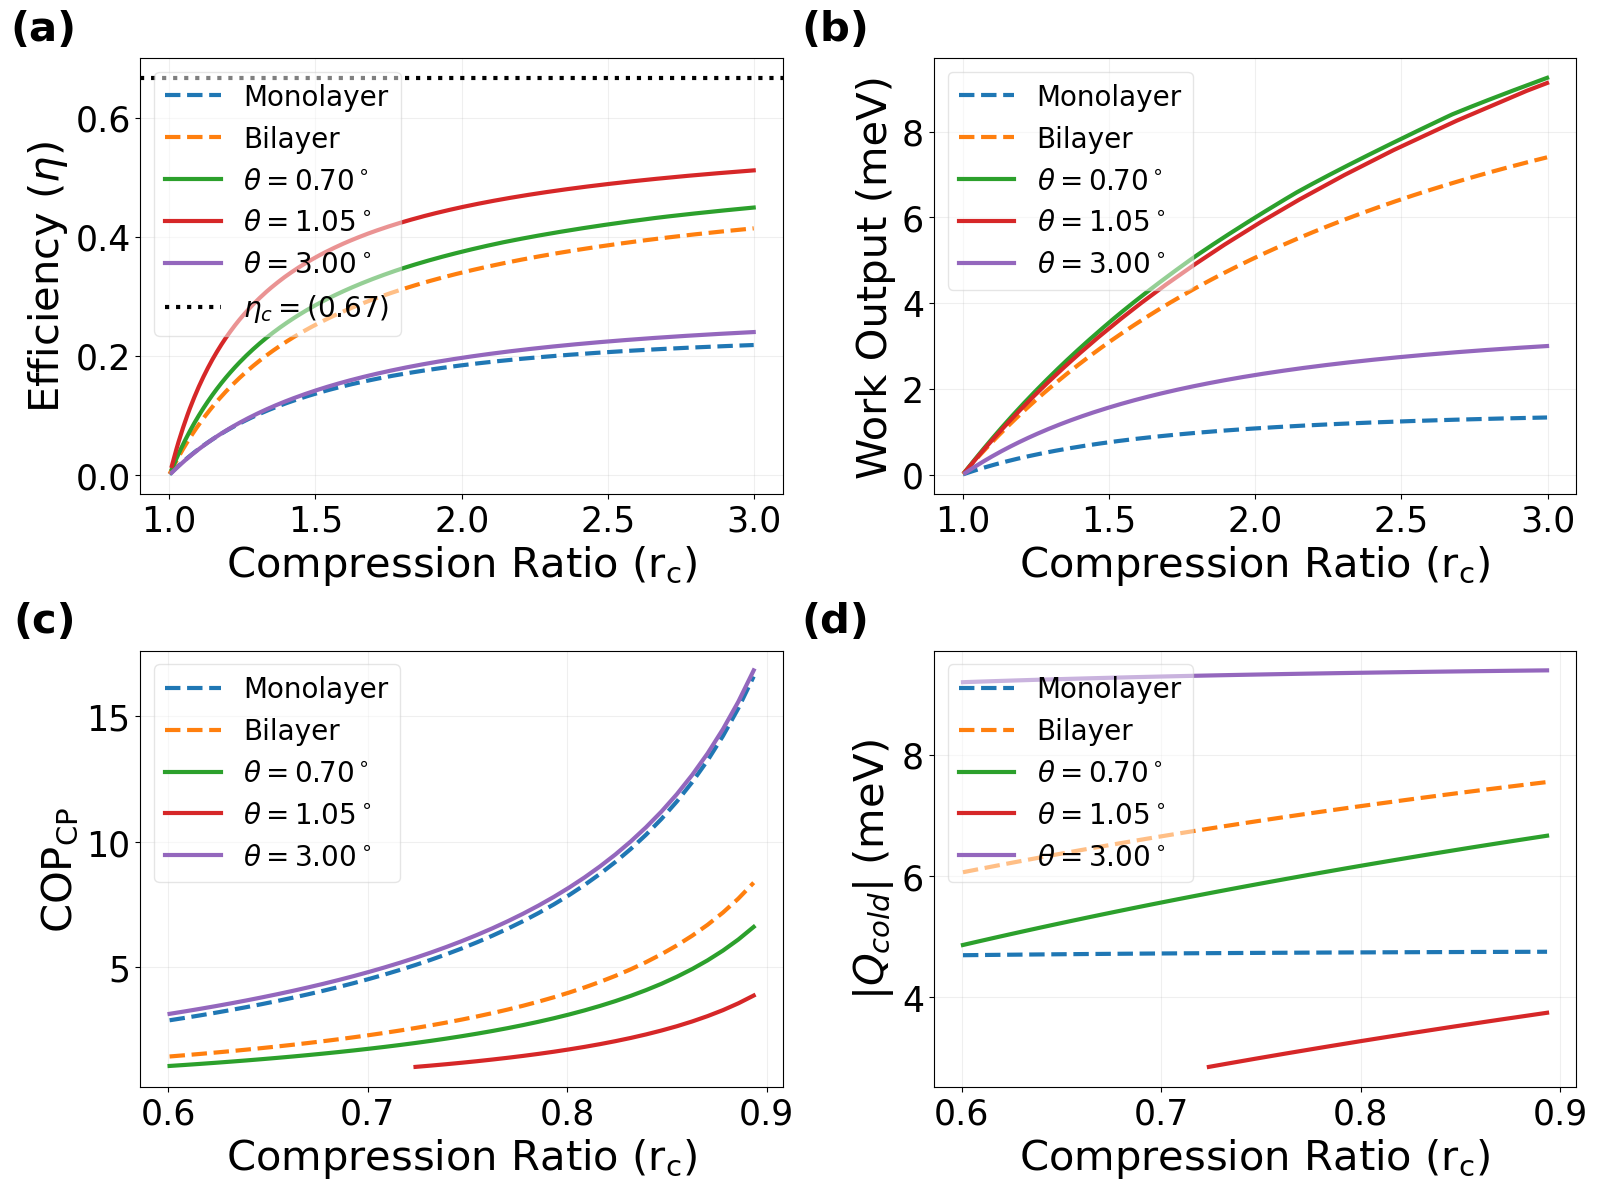

In [7]:
T_hot=150
T_cold =50

carnot_eff = 1 - T_cold / T_hot  
carnot_cop= T_cold /(T_hot-T_cold)

B1 = 1  # Magnetic field in Tesla


# Angles in radians

Theta_deg = ["Monolayer", "Bilayer", 0.7, 1.05, 3]
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]

Ratio = np.linspace(0.3, 8, 1000)

# Data Storage
all_efficiencies_HE = {}
all_work_HE = {}
all_rc_HE={}

all_COP_CP = {}
all_Qc_CP = {}
all_rc_CP={}

# Loop over different angles
for theta in Theta:
    
     
    if isinstance(theta, (int, float)):  # If theta is a numerical value
        filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"  #NEW PART
        data = np.load(filename)
        B_vals = data["B_vals"]
        spectra = data["spectra"]    
        idx = np.argmin(np.abs(B_vals - B1))
        Energy_B1 = spectra[idx]
        #X_vals1, Energy_B1, Dotted_1 = Positive_landau_plot(N, B1, theta, N_con)
        #Energy_B1=Hk_twist_landau_spec(N,B1,theta,N_con)
    
    elif theta == "Monolayer":
        Energy_B1=hk_mono_LS(N_con, B1, 0, 0,True)
    
    elif theta == "Bilayer":
        Energy_B1=bi_hk(N_con, B1,True)

    perf_HE, output_HE,rc_HE = [], [] ,[]
    perf_CP, output_CP,rc_CP = [], [] ,[]
    
    all_T_4 , all_T_2=[] ,[]
    all_T_2.append(T_cold)
    all_T_4.append(T_hot)
    
    Count=0
    for rc in Ratio:
        Count+=1
        Heat_in, Heat_out, work, eff, COP_R_CP, COP_JP = QSC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Performance",saved=True)

        if work > 0 and Heat_in > 0 and Heat_out < 0 and rc < 3:
            perf_HE.append(eff)
            output_HE.append(work*1000)
            rc_HE.append(rc)

        elif work < 0 and Heat_in > 0 and Heat_out < 0 and rc > 0.6 and rc < 0.9:
            perf_CP.append(COP_R_CP)
            output_CP.append(np.abs(Heat_out*1000))
            rc_CP.append(rc)

    all_efficiencies_HE[theta] = perf_HE
    all_work_HE[theta] = output_HE
    all_rc_HE[theta] = rc_HE

    all_COP_CP[theta] = perf_CP
    all_Qc_CP[theta] = output_CP
    all_rc_CP[theta] = rc_CP




def plot_data(ax, x_data, y_data, theta_labels, ylabel, legend_loc='best',carnot_line=None, subplot_label=None, show_xname=False):  # New: `show_xname`
    
    if subplot_label:
        ax.annotate(f'({subplot_label})', xy=(-0.10, 1.02), xycoords='axes fraction',
                    fontsize=30, weight='bold', ha='right', va='bottom')
    

    for theta, x, y in zip(Theta, x_data, y_data):
        if isinstance(theta, (int, float)):
            theta_label = f"$\\theta = {np.degrees(theta):.2f}^\\circ$"
            linestyle = "-"
        else:
            theta_label = theta
            linestyle = "--" if theta in ["Monolayer", "Bilayer"] else "-"
        
        if len(x) > 0 and len(y) > 0:
            ax.plot(x, y, label=theta_label, linestyle=linestyle, linewidth=3)
    
    if carnot_line is c_cop:
        ax.axhline(y=carnot_line, color='black', linestyle=':', linewidth=3, 
                   label=rf'$COP_c = ({carnot_line:.2f})$')

    elif carnot_line is c_eff:
        ax.axhline(y=carnot_line, color='black', linestyle=':', linewidth=3, 
                   label=rf'$\eta_c = ({carnot_line:.2f})$')
    
    ax.set_ylabel(ylabel, fontsize=30)
    
    if show_xname:
        ax.set_xlabel(r"Compression Ratio ($\text{r}_\text{c}$)", fontsize=30)  # Show only if `show_xname=True`
    else:
        ax.set_xlabel("")  # Hide otherwise
    
    ax.legend(fontsize=20, loc=legend_loc, framealpha=0.5)


fig1, axs1 = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for ax in axs1.flat:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)

# Heat Engine - General
plot_data(axs1[0,0], 
          [all_rc_HE[theta] for theta in Theta], 
          [all_efficiencies_HE[theta] for theta in Theta],
          Theta,
          r"Efficiency ($\eta$)",
          carnot_line=c_eff,
          subplot_label='a',
          show_xname=True)


plot_data(axs1[0,1], 
          [all_rc_HE[theta] for theta in Theta], 
          [all_work_HE[theta] for theta in Theta],
          Theta,
          r"Work Output (meV)",
          subplot_label='b',
          show_xname=True)

plot_data(axs1[1,0], 
          [all_rc_CP[theta] for theta in Theta], 
          [all_COP_CP[theta] for theta in Theta],
          Theta,
          r"$\mathrm{COP}_\mathrm{CP}$", 
          subplot_label='c',
          show_xname=True)


plot_data(axs1[1,1], 
          [all_rc_CP[theta] for theta in Theta], 
          [all_Qc_CP[theta] for theta in Theta],
          Theta,
          r"$|Q_{cold}|$ (meV)", 
          subplot_label='d',
          show_xname=True)

plt.tight_layout()
plt.show()

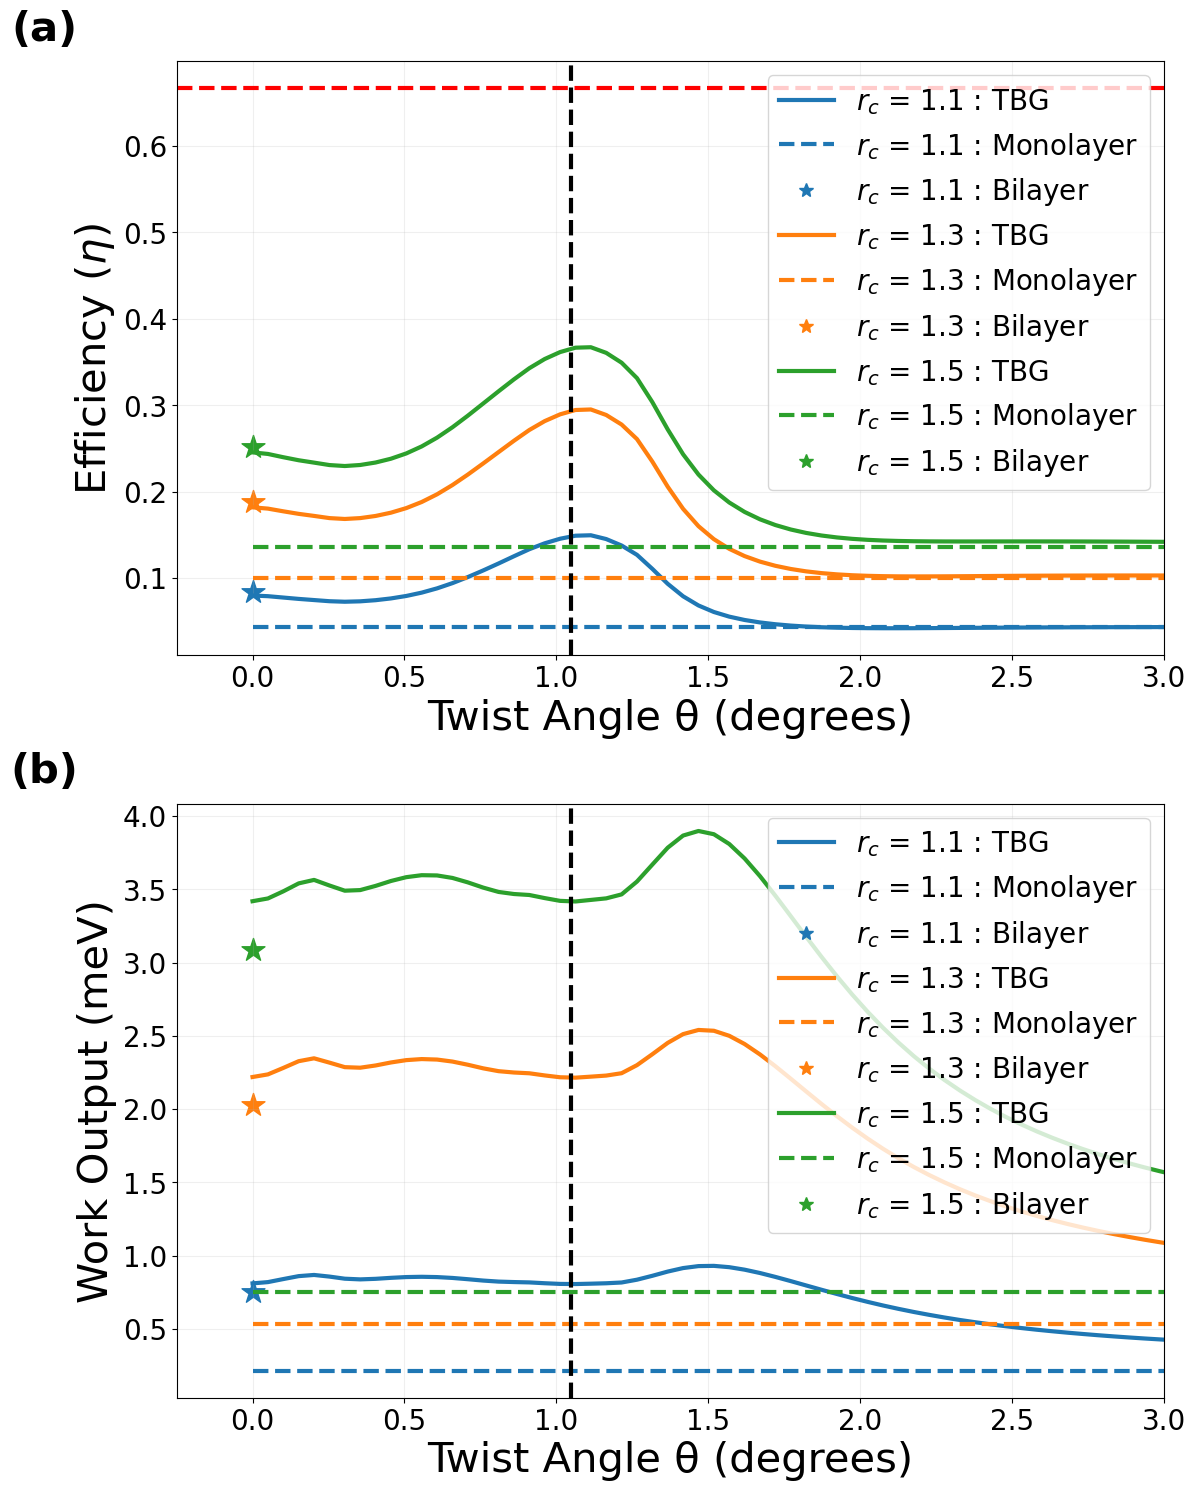

In [9]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)
B1 = 1  # Magnetic field in Tesla

carnot_eff = 1 - T_cold / T_hot 
carnot_cop= T_cold /(T_hot-T_cold)

Theta_deg = ["Monolayer", "Bilayer"] + np.linspace(0.0001, 4, 80).tolist()
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]


rc_values = [1.1, 1.3, 1.5]


efficiencies_dict = {rc: [] for rc in rc_values}
work_dict = {rc: [] for rc in rc_values}


monolayer_eff = {rc: None for rc in rc_values}
bilayer_eff = {rc: None for rc in rc_values}
monolayer_work = {rc: None for rc in rc_values}
bilayer_work = {rc: None for rc in rc_values}


valid_theta_deg = []

Count=0
for theta in Theta:
    Count+=1
   
    
    if isinstance(theta, (int, float)):
        data = np.load(f"spectrum_theta_sweep_N{N}_rc{B1}_Ncon{N_con}_steps80.npz")
        idx = np.argmin(np.abs(data["theta_vals_deg"] - np.round(np.degrees(theta), 2)))
        Energy_B1 = data["spectra"][idx]
    elif theta == "Monolayer":
        Energy_B1 = hk_mono_LS(N_con, B1, 0, 0, True)
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)
    

    valid = True
    temp_eff = {rc: None for rc in rc_values}
    temp_work = {rc: None for rc in rc_values}
    
    for rc in rc_values:
        
        Heat_in, Heat_out, work, eff, _, _ = QSC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Twist",saved=True)
       
        if eff is None or work is None:
            valid = False
            break
        if Heat_in >0 and Heat_out <0 and work >0:
            temp_eff[rc] = eff
            temp_work[rc] = work *1000
    
    if not valid and isinstance(theta, (int, float)):
        continue
    
    if isinstance(theta, (int, float)):
        valid_theta_deg.append(np.degrees(theta))
    
    for rc in rc_values:
        if theta == "Monolayer":
            monolayer_eff[rc] = temp_eff[rc]
            monolayer_work[rc] = temp_work[rc]
        elif theta == "Bilayer":
            bilayer_eff[rc] = temp_eff[rc]
            bilayer_work[rc] = temp_work[rc]
        else:
            efficiencies_dict[rc].append(temp_eff[rc])
            work_dict[rc].append(temp_work[rc])


fig, axs = plt.subplots(2, 1, figsize=(12, 15))
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.grid(True, alpha=0.2)

# LEFT PLOT — Efficiency vs θ
ax = axs[0]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_eff = [val for val in efficiencies_dict[rc] if val is not None]
    valid_theta = [theta for theta, val in zip(valid_theta_deg, efficiencies_dict[rc]) if val is not None]

    if valid_eff:
        line, = ax.plot(valid_theta, valid_eff, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')

        if monolayer_eff[rc] is not None:
            ax.hlines(monolayer_eff[rc], 0, max(valid_theta), colors=color, linestyles='--', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')
        if bilayer_eff[rc] is not None:
            ax.scatter(0, bilayer_eff[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r'Efficiency ($\eta$)', fontsize=30)
ax.axhline(y=carnot_eff, color='red', linestyle='--', linewidth=3, label='Carnot Efficiency')
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.set_xlim(-0.25, 3)
ax.annotate(f'(a)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.legend(legend_handles, legend_labels, fontsize=20, loc='best')

# RIGHT PLOT — Work Output vs θ
ax = axs[1]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_work = [val for val in work_dict[rc] if val is not None]
    valid_theta = [theta for theta, val in zip(valid_theta_deg, work_dict[rc]) if val is not None]

    if valid_work:
        line, = ax.plot(valid_theta, valid_work, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')

        if monolayer_work[rc] is not None:
            ax.hlines(monolayer_work[rc], 0, max(valid_theta), colors=color, linestyles='--', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')
        if bilayer_work[rc] is not None:
            ax.scatter(0, bilayer_work[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel('Work Output (meV)', fontsize=30)
ax.set_xlim(-0.25,3)
ax.annotate(f'(b)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.legend(legend_handles, legend_labels, fontsize=20, loc='upper right')
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
plt.tight_layout()
plt.show()


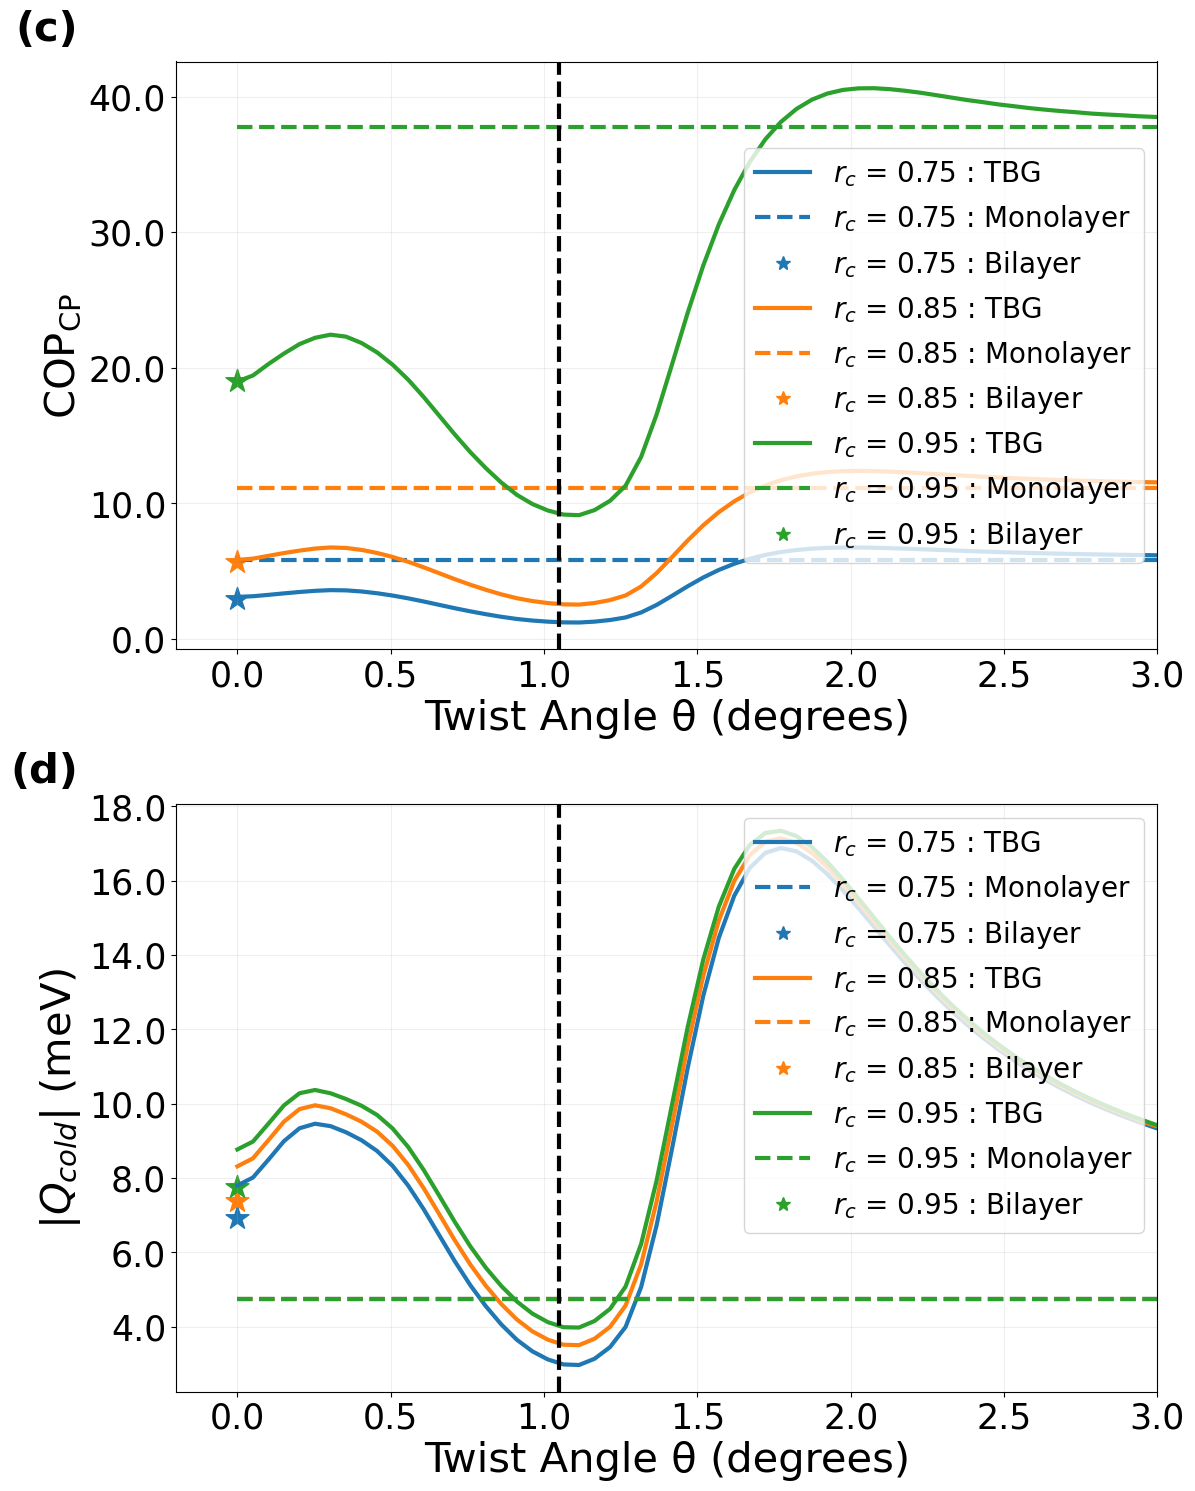

In [10]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)

B1 = 1  # Magnetic field in Tesla


Theta_deg = ["Monolayer", "Bilayer"] + np.linspace(0.0001, 4, 80).tolist()
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]


rc_values = [0.75, 0.85, 0.95]


cop_dict = {rc: [] for rc in rc_values}
work_dict = {rc: [] for rc in rc_values}

monolayer_cop = {rc: None for rc in rc_values}
bilayer_cop = {rc: None for rc in rc_values}
monolayer_work = {rc: None for rc in rc_values}
bilayer_work = {rc: None for rc in rc_values}

valid_theta_deg = []

for theta in Theta:
    
    if isinstance(theta, (int, float)):
        data = np.load(f"spectrum_theta_sweep_N{N}_rc{B1}_Ncon{N_con}_steps80.npz")
        idx = np.argmin(np.abs(data["theta_vals_deg"] - np.round(np.degrees(theta), 2)))
        Energy_B1 = data["spectra"][idx]
    elif theta == "Monolayer":
        Energy_B1 = hk_mono_LS(N_con, B1, 0, 0, True)
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)

    temp_cop = {rc: None for rc in rc_values}
    temp_work = {rc: None for rc in rc_values}
    
    for rc in rc_values:
        
        Heat_in, Heat_out, work, eff, COP_R_CP, COP_JP = QSC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Twist",saved=True)
       
        if work < 0 and Heat_in > 0 and Heat_out < 0:
            
            temp_cop[rc] = COP_R_CP
            temp_work[rc] = np.abs(Heat_out*1000)
    

    if any(v is not None for v in temp_cop.values()) or not isinstance(theta, (int, float)):
        
        if isinstance(theta, (int, float)):
            valid_theta_deg.append(np.degrees(theta))
        
        for rc in rc_values:
            if theta == "Monolayer":
                monolayer_cop[rc] = temp_cop[rc]
                monolayer_work[rc] = temp_work[rc]
            elif theta == "Bilayer":
                bilayer_cop[rc] = temp_cop[rc]
                bilayer_work[rc] = temp_work[rc]
            else:
                cop_dict[rc].append(temp_cop[rc])
                work_dict[rc].append(temp_work[rc])

fig, axs = plt.subplots(2, 1, figsize=(12, 15))

# Shared formatting
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)

# LEFT PLOT — COP vs θ
ax = axs[0]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_cop = [val for val in cop_dict[rc] if val is not None]
    valid_theta = [theta for theta, val in zip(valid_theta_deg, cop_dict[rc]) if val is not None]
    
    if valid_cop:
        line, = ax.plot(valid_theta, valid_cop, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')
        
        if monolayer_cop[rc] is not None:
            ax.hlines(monolayer_cop[rc], 0, max(valid_theta), colors=color, linestyles='--', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')
        
        if bilayer_cop[rc] is not None:
            ax.scatter(0, bilayer_cop[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')




ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r"$\mathrm{COP}_\mathrm{CP}$", fontsize=30)
ax.set_xlim(-0.2, 3)
ax.annotate(f'(c)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.legend(legend_handles, legend_labels, fontsize=20, loc='center right')

# RIGHT PLOT — Work Input vs θ
ax = axs[1]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_work = [val for val in work_dict[rc] if val is not None]
    valid_theta = [theta for theta, val in zip(valid_theta_deg, work_dict[rc]) if val is not None]
    
    if valid_work:
        line, = ax.plot(valid_theta, valid_work, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG ')
        
        if monolayer_work[rc] is not None:
            ax.hlines(monolayer_work[rc], 0, max(valid_theta), colors=color, linestyles='--', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')
        
        if bilayer_work[rc] is not None:
            ax.scatter(0, bilayer_work[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r'$|Q_{cold}|$ (meV)', fontsize=30)
ax.set_xlim(-0.2, 3)
ax.annotate(f'(d)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.legend(legend_handles, legend_labels, fontsize=20, loc='upper right')
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
plt.tight_layout()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
plt.show()
